In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy import ndimage

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
np.random.seed(42)
torch.manual_seed(42)

CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"

In [3]:
with h5py.File(CUBE_PATH, "r") as cube:
    spectra = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:]
    images = cube["dense_cube/0/ml_image/cutout_3d_cube_zoom_0"][:]
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]

sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")
valid_sfrs = sfrs[(sfrs["FLAG"] == 0.0) & (sfrs["Z"].notna())].copy()

In [4]:
metadata_indices = metadata[:, 0]["ds_slice_idx"]
mask = np.in1d(metadata_indices, valid_sfrs.index)

with h5py.File(CUBE_PATH, "r") as cube:
    spectra_zoom0 = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:][mask]
    images_zoom0 = cube["dense_cube/0/ml_image/cutout_3d_cube_zoom_0"][:][mask]

metadata_indices_filtered = metadata_indices[mask]
labels = valid_sfrs.loc[metadata_indices_filtered, "TARGETTYPE"]

In [5]:
def simplify_targettype(val):
    if isinstance(val, bytes):
        val = val.decode("utf-8").strip()
    else:
        val = str(val).strip()
    return "GALAXY" if "GALAXY" in val else "OTHER"

labels_simplified = pd.Series(labels).apply(simplify_targettype).values
galaxy_mask = labels_simplified == "GALAXY"
valid_indices = ~np.isnan(spectra_zoom0).any(axis=1)
final_mask = galaxy_mask & valid_indices
print("Number of objects after filtering:", final_mask.sum())

Number of objects after filtering: 10126


In [6]:
Y_all = valid_sfrs.loc[metadata_indices_filtered, "AVG"].values
Y = Y_all[final_mask]

In [7]:
filters = ["u", "g", "r", "i", "z"]

all_images = []
all_spectra = []

for zoom in range(4):
    img_key = f"dense_cube/{zoom}/ml_image/cutout_3d_cube_zoom_{zoom}"
    spec_key = f"dense_cube/{zoom}/ml_spectrum/spectral_1d_cube_zoom_{zoom}"
    
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom = cube[img_key][:][mask]
        spectra_zoom = cube[spec_key][:][mask]
    
    images_zoom = images_zoom[final_mask]
    spectra_zoom = spectra_zoom[final_mask]
    
    if zoom == 0:
        reference_spectrum = spectra_zoom.copy()
        reference_images = images_zoom.copy()
    
    min_val_spec = np.min(reference_spectrum, axis=1, keepdims=True)
    max_val_spec = np.max(reference_spectrum, axis=1, keepdims=True)
    spectra_zoom_normalized = 2 * (spectra_zoom - min_val_spec) / (max_val_spec - min_val_spec) - 1
    
    min_val_img = np.min(reference_images, axis=(2, 3), keepdims=True)
    max_val_img = np.max(reference_images, axis=(2, 3), keepdims=True)
    images_zoom_normalized = 2 * (images_zoom - min_val_img) / (max_val_img - min_val_img) - 1
    
    all_images.append(images_zoom_normalized)
    all_spectra.append(spectra_zoom_normalized)

In [8]:
def detect_and_visualize_multiple_objects(all_images, thresholds, max_objects=20, thumbnail_size=3, crop_sizes=None):
    all_images_trimmed = []
    for i, img_array in enumerate(all_images):
        original_size = img_array.shape[-1]
        target_size = crop_sizes.get(i, original_size)
        
        start = (original_size - target_size) // 2
        end = start + target_size
        
        trimmed = img_array[..., start:end, start:end]
        all_images_trimmed.append(trimmed)
    
    multi_obj_indices = []
    for idx in range(all_images_trimmed[0].shape[0]):
        image = all_images_trimmed[0][idx, 2, :, :]
        image_normalized = (image + 1) / 2
        binary = image_normalized > thresholds[0]
        labeled, num_features = ndimage.label(binary)
        if num_features > 1:
            multi_obj_indices.append(idx)

    if len(multi_obj_indices) > max_objects:
        print(f"Found {len(multi_obj_indices)} objects. Showing first {max_objects}")
        multi_obj_indices = multi_obj_indices[:max_objects]

    if not multi_obj_indices:
        print("No multi-object sources found")
        return all_images_trimmed
    
    num_rows = len(multi_obj_indices)
    fig, axes = plt.subplots(
        num_rows,
        5,
        figsize=(15, thumbnail_size * num_rows),
        dpi=100
    )
    
    if num_rows == 1:
        axes = axes.reshape(1, -1)

    for row, obj_idx in enumerate(multi_obj_indices):
        for col in range(5):
            ax = axes[row, col]
            img_data = all_images_trimmed[0][obj_idx, col, :, :]
            ax.imshow(img_data, vmin=-1, vmax=1)
            ax.set_title(f"Filter {filters[col]}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()
    return all_images_trimmed

In [9]:
THRESHOLDS_4 = {
    0: 0.90,
    1: 0.93,
    2: 0.97,
    3: 0.99
}

CROP_SIZES_4 = {
    0: 32, 
    1: 16, 
    2: 8, 
    3: 4   
}

In [10]:
cropped_images = []
for zoom in range(4):
    img_array = all_images[zoom]
    original_size = img_array.shape[-1]
    target_size = CROP_SIZES_4.get(zoom, original_size)
    start = (original_size - target_size) // 2
    end = start + target_size
    cropped = img_array[..., start:end, start:end]
    cropped_images.append(cropped)

In [11]:
# Dictionary to store results for each spectra zoom level
results_fusion = {}

# Use the fixed image modality from cropped_images[0]
X_img = cropped_images[0]
n_samples = X_img.shape[0]
X_img = X_img.reshape(n_samples, -1)  # flatten images

In [14]:
X_img_train, X_img_temp, X_spec_train, X_spec_temp, y_train, y_temp = train_test_split(
    X_img, all_spectra[:][0], Y, test_size=0.4, random_state=42)

X_img_val, X_img_test, X_spec_val, X_spec_test, y_val, y_test = train_test_split(
    X_img_temp, X_spec_temp, y_temp, test_size=0.5, random_state=42)


In [15]:
img_pca_components = 100
spec_pca_components = 50
learning_rate = 0.0005
batch_size = 64
epochs = 100
patience = 10

scaler_img = StandardScaler().fit(X_img_train)
scaler_spec = StandardScaler().fit(X_spec_train)

X_img_train_scaled = scaler_img.transform(X_img_train)
X_spec_train_scaled = scaler_spec.transform(X_spec_train)

# PCA
pca_img = PCA(n_components=img_pca_components).fit(X_img_train_scaled)
pca_spec = PCA(n_components=spec_pca_components).fit(X_spec_train_scaled)

X_img_train_pca = pca_img.transform(X_img_train_scaled)
X_spec_train_pca = pca_spec.transform(X_spec_train_scaled)

In [16]:
# Transform validation and test
X_img_val_pca = pca_img.transform(scaler_img.transform(X_img_val))
X_spec_val_pca = pca_spec.transform(scaler_spec.transform(X_spec_val))

X_img_test_pca = pca_img.transform(scaler_img.transform(X_img_test))
X_spec_test_pca = pca_spec.transform(scaler_spec.transform(X_spec_test))

In [17]:
# To tensor function
def to_tensor(x):
    return torch.tensor(x, dtype=torch.float32)

# Data loaders
train_ds = TensorDataset(to_tensor(X_img_train_pca), to_tensor(X_spec_train_pca), to_tensor(y_train))
val_ds = TensorDataset(to_tensor(X_img_val_pca), to_tensor(X_spec_val_pca), to_tensor(y_val))
test_ds = TensorDataset(to_tensor(X_img_test_pca), to_tensor(X_spec_test_pca), to_tensor(y_test))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

In [18]:
# Early Fusion Model
class EarlyFusionNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# Intermediate Fusion Model
class IntermediateFusionNet(nn.Module):
    def __init__(self, img_dim, spec_dim):
        super().__init__()
        self.img_branch = nn.Sequential(
            nn.Linear(img_dim, 64), nn.ReLU(), nn.Dropout(0.3)
        )
        self.spec_branch = nn.Sequential(
            nn.Linear(spec_dim, 32), nn.ReLU(), nn.Dropout(0.3)
        )
        self.fusion = nn.Sequential(
            nn.Linear(96, 32), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(32, 1)
        )

    def forward(self, img, spec):
        img_feat = self.img_branch(img)
        spec_feat = self.spec_branch(spec)
        combined = torch.cat([img_feat, spec_feat], dim=1)
        return self.fusion(combined)

# Late Fusion Model
class LateFusionNet(nn.Module):
    def __init__(self, img_dim, spec_dim):
        super().__init__()
        self.img_net = nn.Sequential(
            nn.Linear(img_dim, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
        self.spec_net = nn.Sequential(
            nn.Linear(spec_dim, 32), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, img, spec):
        img_pred = self.img_net(img)
        spec_pred = self.spec_net(spec)
        return (img_pred + spec_pred) / 2

In [19]:
early_model = EarlyFusionNet(img_pca_components + spec_pca_components)
intermediate_model = IntermediateFusionNet(img_pca_components, spec_pca_components)
late_model = LateFusionNet(img_pca_components, spec_pca_components)

In [22]:
criterion = nn.MSELoss()

def train_model(model, train_loader, val_loader, epochs, patience):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    best_val_loss = np.inf
    patience_counter = 0

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for batch in train_loader:
            optimizer.zero_grad()
            img, spec, y = batch

            if isinstance(model, EarlyFusionNet):
                inputs = torch.cat([img, spec], dim=1)
                pred = model(inputs).squeeze()
            else:
                pred = model(img, spec).squeeze()

            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for img, spec, y in val_loader:
                if isinstance(model, EarlyFusionNet):
                    inputs = torch.cat([img, spec], dim=1)
                    pred = model(inputs).squeeze()
                else:
                    pred = model(img, spec).squeeze()

                loss = criterion(pred, y)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_weights = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                model.load_state_dict(best_model_weights)
                break

    # Visualization of training
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.axvline(x=len(train_losses)-patience_counter, color='r', linestyle='--', label='Early Stopping Triggered')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch 1/100, Train Loss: 0.2642, Validation Loss: 0.3635
Epoch 2/100, Train Loss: 0.2560, Validation Loss: 0.3709
Epoch 3/100, Train Loss: 0.2579, Validation Loss: 0.3689
Epoch 4/100, Train Loss: 0.2590, Validation Loss: 0.3677
Epoch 5/100, Train Loss: 0.2543, Validation Loss: 0.3678
Epoch 6/100, Train Loss: 0.2458, Validation Loss: 0.3647
Epoch 7/100, Train Loss: 0.2464, Validation Loss: 0.3665
Epoch 8/100, Train Loss: 0.2432, Validation Loss: 0.3688
Epoch 9/100, Train Loss: 0.2441, Validation Loss: 0.3728
Epoch 10/100, Train Loss: 0.2468, Validation Loss: 0.3677
Epoch 11/100, Train Loss: 0.2404, Validation Loss: 0.3631
Epoch 12/100, Train Loss: 0.2366, Validation Loss: 0.3704
Epoch 13/100, Train Loss: 0.2352, Validation Loss: 0.3699
Epoch 14/100, Train Loss: 0.2364, Validation Loss: 0.3667
Epoch 15/100, Train Loss: 0.2334, Validation Loss: 0.3711
Epoch 16/100, Train Loss: 0.2274, Validation Loss: 0.3771
Epoch 17/100, Train Loss: 0.2347, Validation Loss: 0.3721
Epoch 18/100, Train Los

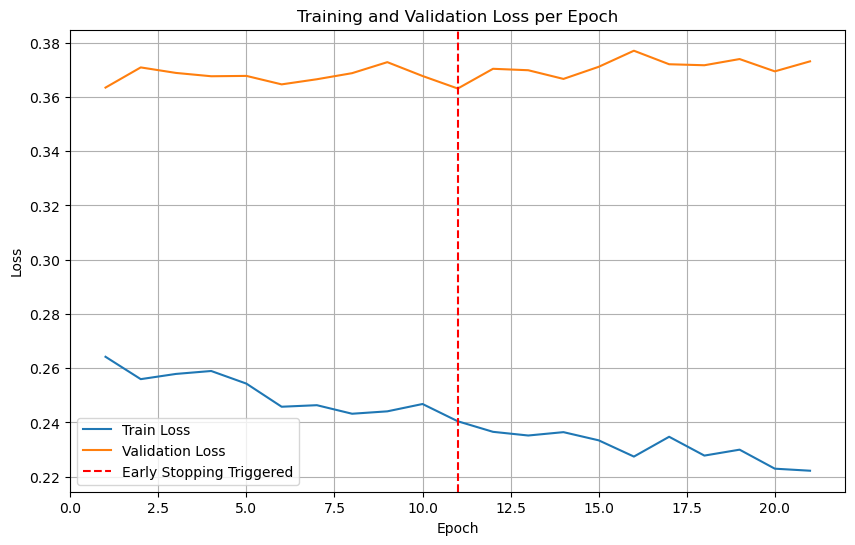

Epoch 1/100, Train Loss: 0.2973, Validation Loss: 0.3563
Epoch 2/100, Train Loss: 0.3018, Validation Loss: 0.3563
Epoch 3/100, Train Loss: 0.2967, Validation Loss: 0.3552
Epoch 4/100, Train Loss: 0.2908, Validation Loss: 0.3567
Epoch 5/100, Train Loss: 0.2946, Validation Loss: 0.3572
Epoch 6/100, Train Loss: 0.2904, Validation Loss: 0.3594
Epoch 7/100, Train Loss: 0.2953, Validation Loss: 0.3585
Epoch 8/100, Train Loss: 0.2927, Validation Loss: 0.3573
Epoch 9/100, Train Loss: 0.2882, Validation Loss: 0.3579
Epoch 10/100, Train Loss: 0.2913, Validation Loss: 0.3548
Epoch 11/100, Train Loss: 0.2872, Validation Loss: 0.3538
Epoch 12/100, Train Loss: 0.2843, Validation Loss: 0.3569
Epoch 13/100, Train Loss: 0.2824, Validation Loss: 0.3571
Epoch 14/100, Train Loss: 0.2807, Validation Loss: 0.3597
Epoch 15/100, Train Loss: 0.2798, Validation Loss: 0.3570
Epoch 16/100, Train Loss: 0.2829, Validation Loss: 0.3594
Epoch 17/100, Train Loss: 0.2832, Validation Loss: 0.3579
Epoch 18/100, Train Los

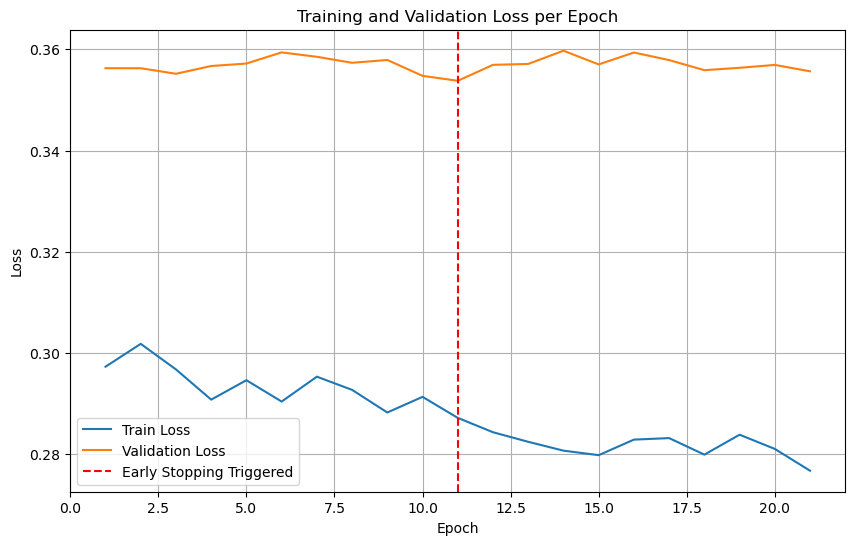

Epoch 1/100, Train Loss: 0.3279, Validation Loss: 0.3695
Epoch 2/100, Train Loss: 0.3240, Validation Loss: 0.3704
Epoch 3/100, Train Loss: 0.3200, Validation Loss: 0.3716
Epoch 4/100, Train Loss: 0.3184, Validation Loss: 0.3733
Epoch 5/100, Train Loss: 0.3225, Validation Loss: 0.3728
Epoch 6/100, Train Loss: 0.3222, Validation Loss: 0.3716
Epoch 7/100, Train Loss: 0.3189, Validation Loss: 0.3711
Epoch 8/100, Train Loss: 0.3187, Validation Loss: 0.3739
Epoch 9/100, Train Loss: 0.3200, Validation Loss: 0.3706
Epoch 10/100, Train Loss: 0.3202, Validation Loss: 0.3731
Epoch 11/100, Train Loss: 0.3163, Validation Loss: 0.3712
Early stopping triggered at epoch 11


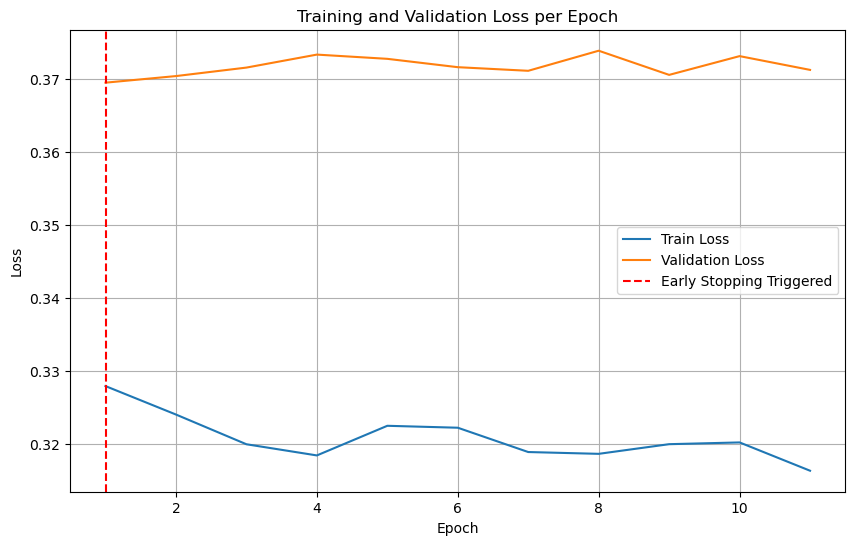

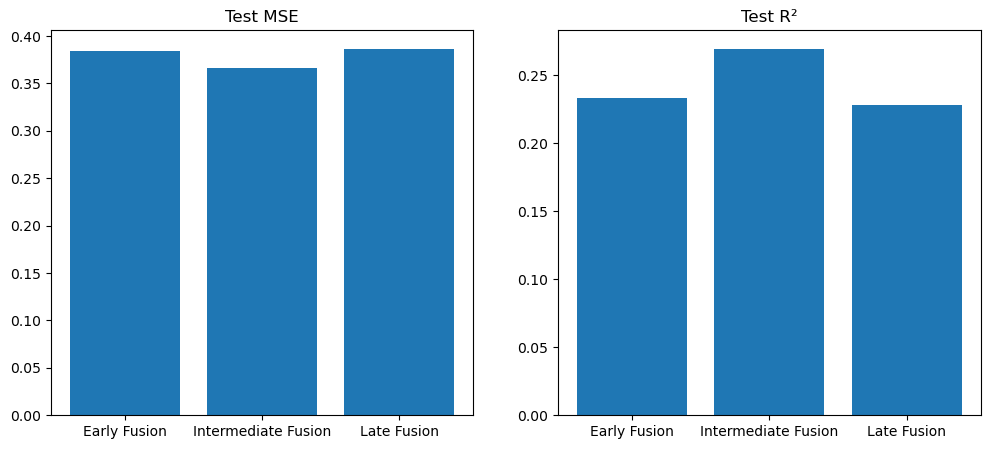

In [23]:
# Train and visualize results for each model
def evaluate_model(model, test_loader):
    model.eval()
    preds, ys = [], []
    with torch.no_grad():
        for img, spec, y in test_loader:
            pred = model(torch.cat([img, spec], dim=1)).squeeze() if isinstance(model, EarlyFusionNet) else model(img, spec).squeeze()
            preds.extend(pred.numpy())
            ys.extend(y.numpy())
    return mean_squared_error(ys, preds), r2_score(ys, preds)

# Visualization
models = [early_model, intermediate_model, late_model]
names = ['Early Fusion', 'Intermediate Fusion', 'Late Fusion']
results = []

for model, name in zip(models, names):
    train_model(model, train_loader, val_loader, epochs, patience)
    mse, r2 = evaluate_model(model, test_loader)
    results.append((name, mse, r2))

# Plot results
names, mses, r2s = zip(*results)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.bar(names, mses)
plt.title('Test MSE')
plt.subplot(1,2,2)
plt.bar(names, r2s)
plt.title('Test R²')
plt.show()
